By Suchin Gururangan and Swabha Swayamdipta, 2018; Modified by Sam Bowman, 2019; MIT License

Used to produce the PPMI statistics shown in this paper:
https://www.aclweb.org/anthology/N18-2017/

# PPMI Distributions

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
from collections import Counter
import string
from IPython.core.debugger import Tracer
import numpy as np
from nltk import PorterStemmer
from nltk.tokenize import word_tokenize
%matplotlib inline

## Load Data

In [22]:
# A few warnings are expected here due to format mismatches. These should not impact the target calculations.
mnli = pd.read_csv('/Users/srbowman/glue_data/MNLI/train.tsv',
                   sep = '\t',
                   error_bad_lines=False).dropna(subset=['sentence2'])
mnli = mnli[mnli['genre'] == 'government']  # Using only the 'government' genre section of MNLI here
mnli = mnli[0:9000]  # Trimming this to match the size of the other datasets under study.
mnli[0:10]

b'Skipping line 24810: expected 12 fields, saw 13\nSkipping line 33961: expected 12 fields, saw 13\n'
b'Skipping line 75911: expected 12 fields, saw 13\nSkipping line 100114: expected 12 fields, saw 13\n'
b'Skipping line 150638: expected 12 fields, saw 13\nSkipping line 158834: expected 12 fields, saw 13\nSkipping line 173104: expected 12 fields, saw 13\nSkipping line 178252: expected 12 fields, saw 13\n'
b'Skipping line 221951: expected 12 fields, saw 13\n'
b'Skipping line 286845: expected 12 fields, saw 13\nSkipping line 314110: expected 12 fields, saw 13\n'


,index,promptID,pairID,genre,sentence1_binary_parse,sentence2_binary_parse,sentence1_parse,sentence2_parse,sentence1,sentence2,label1,gold_label
0,0,31193,31193n,government,( ( Conceptually ( cream skimming ) ) ( ( has ...,( ( ( Product and ) geography ) ( ( are ( what...,(ROOT (S (NP (JJ Conceptually) (NN cream) (NN ...,(ROOT (S (NP (NN Product) (CC and) (NN geograp...,Conceptually cream skimming has two basic dime...,Product and geography are what make cream skim...,neutral,neutral
14,14,102489,102489c,government,( ( ( ( ( I ( ( do n't ) ( mean ( to ( be ( gl...,( I ( ( am ( ( concerned ( more ( about ( your...,(ROOT (S (S (NP (PRP I)) (VP (VBP do) (RB n't)...,(ROOT (S (NP (PRP I)) (VP (VBP am) (VP (VBN co...,"I don't mean to be glib about your concerns, b...",I am concerned more about your issues than the...,contradiction,contradiction
15,15,81785,81785e,government,( ( Issues ( in ( Data Synthesis ) ) ) . ),( ( Problems ( in ( data synthesis ) ) ) . ),(ROOT (NP (NP (NNS Issues)) (PP (IN in) (NP (N...,(ROOT (NP (NP (NNS Problems)) (PP (IN in) (NP ...,Issues in Data Synthesis.,Problems in data synthesis.,entailment,entailment
18,18,101211,101211c,government,( ( ( This analysis ) pooled ) ( ( ( estimates...,( ( The analysis ) ( ( proves ( that ( there (...,(ROOT (S (NP (NP (DT This) (NN analysis)) (VP ...,(ROOT (S (NP (DT The) (NN analysis)) (VP (VBZ ...,This analysis pooled estimates from these two ...,The analysis proves that there is no link betw...,contradiction,contradiction
20,20,38518,38518e,government,( We ( ( sought ( to ( identify ( practices ( ...,( We ( want ( to ( identify ( practices ( comm...,(ROOT (S (NP (PRP We)) (VP (VBD sought) (S (VP...,(ROOT (S (NP (PRP We)) (VP (VBP want) (S (VP (...,We sought to identify practices that were comm...,We want to identify practices commonly used by...,entailment,entailment
22,22,76011,76011c,government,( States ( ( must ( ( show ( ( reasonable prog...,( ( ( Itis ( not necessary ) ) ( for ( there (...,(ROOT (S (NP (NNPS States)) (VP (MD must) (VP ...,(ROOT (S (VP (VB Itis) (ADJP (RB not) (JJ nece...,States must show reasonable progress in their ...,Itis not necessary for there to be any improve...,contradiction,contradiction
29,29,22086,22086e,government,( ( Postal Service ) ( ( were ( to ( reduce ( ...,( ( The ( postal service ) ) ( ( could ( deliv...,(ROOT (S (NP (NNP Postal) (NNP Service)) (VP (...,(ROOT (S (NP (DT The) (JJ postal) (NN service)...,Postal Service were to reduce delivery frequency.,The postal service could deliver less frequently.,entailment,entailment
31,31,73578,73578e,government,( ( The rule ) ( ( contains ( ( information ( ...,( ( The rule ) ( ( has ( ( data ( collection r...,(ROOT (S (NP (DT The) (NN rule)) (VP (VBZ cont...,(ROOT (S (NP (DT The) (NN rule)) (VP (VBZ has)...,The rule contains information collection requi...,The rule has data collection requirements whic...,entailment,entailment
41,41,12538,12538n,government,( ( When ( ( the ( trust fund ) ) ( begins ( (...,( ( The public ) ( ( ( would generally ) ( pre...,(ROOT (S (SBAR (WHADVP (WRB When)) (S (NP (DT ...,(ROOT (S (NP (DT The) (NN public)) (VP (MD wou...,When the trust fund begins running cash defici...,The public would generally prefer to see the g...,neutral,neutral
42,42,144037,144037e,government,( ( These organizations ) ( ( ( invest ( the (...,( ( These organizations ) ( invest ( ( lots ( ...,(ROOT (S (NP (DT These) (NNS organizations)) (...,(ROOT (S (NP (DT These) (NNS organizations)) (...,These organizations invest the time and effort...,These organizations invest lots of time to und...,entailment,entailment


## Functions

In [30]:
def tokenize(string):
    """
    tokenize string from binary parse
    """

    tokens = word_tokenize(string.lower())
    return tokens

def pmi(df):
    """
    PPMI
    Args:
        df -> dataframe (mnli or snli)
    Returns:
        pmis -> pmi data
    """
    alpha = 10.0
    # get joint (w,c) counts
    Px = []
    Py = []
    Pxy = []
    for idx, row in df.iterrows():
        for word in tokenize(row.sentence2):
            Pxy.append((word, row.gold_label))
            Py.append(row.gold_label)
            # Two-class alternative to the above:
            # Pxy.append((word, "entailment" if row.gold_label == "entailment" else "contradiction"))
            # Py.append("entailment" if row.gold_label == "entailment" else "contradiction")
            Px.append(word)

    Pxy = Counter(Pxy)
    Px = Counter(Px)
    Py = Counter(Py)
    Py = {y: c + len(Px)*alpha for y, c in Py.items()}
    Px = {x: c + 3*alpha for x, c in Px.items()}
    total_word_count = sum(Px.values())

    # get c counts
    pmis = []
    
    seen_pairs = {}
    total_Py = 3
    for word in Px.keys():
        for cls in ['contradiction', 'entailment', 'neutral']:  # Remove 'neutral' for two-class version.
            if seen_pairs.get((word, cls)) is None:
                # artificial smoothing
                word_count = float(Px[word])
                cls_count = float(Py[cls])
                word_cls_count = Pxy.get((word, cls), 0.0) + alpha
                z = (float(word_cls_count) * total_word_count / (float(word_count) * float(cls_count)))
                # ppmi
                pmi = max([np.log(z), 0.0])
                output = {'word': word,
                          'class': cls,
                          'pmi': pmi,
                          'count': word_count - 3*alpha,
                          'wc_count': Pxy.get((word, cls), 0.0),}
                seen_pairs[(word, cls)] = 1
                pmis.append(output)
    pmis = pd.DataFrame(pmis)
    return pmis

## Run PPMI

In [31]:
mnli_pmi = pmi(mnli)

## Top 50 PPMIs across NLI Dataset

In [36]:
sns.set_style("whitegrid", {'axes.grid' : False})
mnli_pmi.sort_values(by='pmi', ascending=False).head(n=50)

,class,count,pmi,wc_count,word
93,contradiction,486.0,0.930506,428.0,no
159,contradiction,222.0,0.801407,178.0,any
735,contradiction,98.0,0.774963,83.0,never
2487,contradiction,48.0,0.707977,43.0,nothing
3030,contradiction,42.0,0.646369,36.0,anything
4116,contradiction,25.0,0.613421,24.0,none
147,contradiction,935.0,0.592167,574.0,not
843,contradiction,230.0,0.564150,143.0,does
360,contradiction,261.0,0.539064,157.0,only
1200,contradiction,26.0,0.534778,22.0,ever


## MNLI class PPMIs

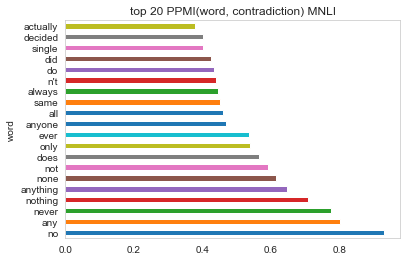

In [33]:
sns.set_style("whitegrid", {'axes.grid' : False})
ax = (mnli_pmi.loc[mnli_pmi['class'] == 'contradiction']
              .sort_values(by='pmi', ascending=False)
              .head(n=20)
              .plot(kind='barh', x='word', y='pmi', title='top 20 PPMI(word, contradiction) MNLI', legend=False))


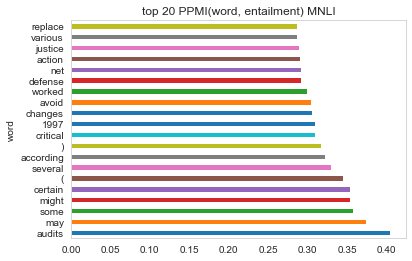

In [34]:
sns.set_style("whitegrid", {'axes.grid' : False})
ax = (mnli_pmi.loc[mnli_pmi['class'] == 'entailment']
              .sort_values(by='pmi', ascending=False)
              .head(n=20)
              .plot(kind='barh', x='word', y='pmi', title='top 20 PPMI(word, entailment) MNLI', legend=False))


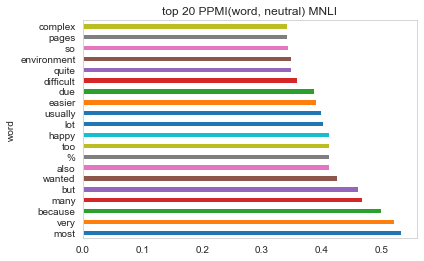

In [35]:
sns.set_style("whitegrid", {'axes.grid' : False})
ax = (mnli_pmi.loc[mnli_pmi['class'] == 'neutral']
              .sort_values(by='pmi', ascending=False)
              .head(n=20)
              .plot(kind='barh', x='word', y='pmi', title='top 20 PPMI(word, neutral) MNLI', legend=False))
